# Part A

## Task 1

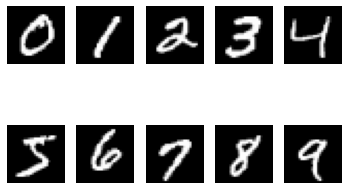

In [6]:
from tensorflow.keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

fig, ax = plt.subplots(2,5)
[axi.set_axis_off() for axi in ax.ravel()]
for i, ax in enumerate(ax.flatten()):
    im_idx = np.argwhere(trainy == i)[0]
    plottable_image = np.reshape(trainX[im_idx], (28, 28))
    ax.imshow(plottable_image, cmap='gray')
plt.show()

## Task 2

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# load dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# 0 -> [0100000000]
	# 1 -> [0100000000]
	#         .......
	# 9 -> [0000000001]
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# define cnn model
def define_model():
	model = Sequential()
	
	model.add(Conv2D(6, (3, 3), strides=(1,1), padding="valid", activation='relu', input_shape=(28, 28, 1)))
	model.add(AveragePooling2D((2, 2), strides=(2,2)))
	model.add(Conv2D(16, (3, 3), strides=(1,1), padding="valid", activation='relu'))
	model.add(AveragePooling2D((2, 2), strides=(2,2)))
	model.add(Flatten())
	model.add(Dense(120, activation='relu'))
	model.add(Dense(84, activation='relu'))
	model.add(Dense(10, activation='softmax'))

	# compile model
	opt = SGD(learning_rate=0.01)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [8]:
from tensorflow.keras.callbacks import  Callback
from tensorflow.keras.callbacks import  LambdaCallback

class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        logs['test_loss'] = loss
        logs['test_accuracy'] = acc
		#print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
		
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def train_model():
	trainX, trainY, testX, testY = load_dataset()
	trainX, testX = prep_pixels(trainX, testX)
	model = define_model()

	result_dic = {"epochs": []}
	json_logging_callback = LambdaCallback(
                on_epoch_end=lambda epoch, logs:
                result_dic["epochs"].append({
                    'epoch': epoch + 1, 
                    'acc': logs['accuracy'],
                    'test_loss': logs['test_loss'],
                    'test_acc': logs['test_accuracy']
                }))

	model.fit(trainX, trainY, epochs=10, batch_size=32, callbacks=[TestCallback((testX, testY)), json_logging_callback])
	model.save('final_model.h5')
	return model, result_dic

model, results_metrics = train_model()

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3088 - accuracy: 0.4676 - test_loss: 0.1887 - test_accuracy: 0.7323
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1369 - accuracy: 0.8050 - test_loss: 0.1004 - test_accuracy: 0.8608
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0935 - accuracy: 0.8638 - test_loss: 0.0805 - test_accuracy: 0.8869
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0784 - accuracy: 0.8863 - test_loss: 0.0700 - test_accuracy: 0.9021
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0684 - accuracy: 0.9008 - test_loss: 0.0613 - test_accuracy: 0.9139
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0612 - accuracy: 0.9113 - test_loss: 0.0553 - test_accuracy: 0.9220
Epoch 7/10
1100/1875 [================>.............] - ETA: 4s - loss: 0.0560 - accuracy: 0.9180

## Task 3

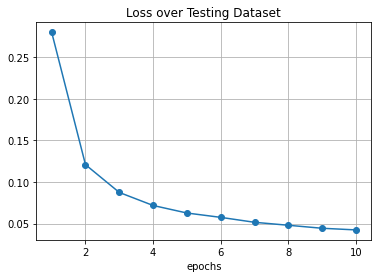

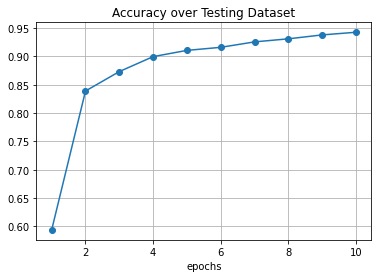

In [4]:
import matplotlib.pyplot as plt
import numpy as np


all_epochs =    [results_metrics['epochs'][i]['epoch']     for i in range(len(results_metrics['epochs']))]
all_test_acc =  [results_metrics['epochs'][i]['test_acc']  for i in range(len(results_metrics['epochs']))]
all_test_loss = [results_metrics['epochs'][i]['test_loss'] for i in range(len(results_metrics['epochs']))]

fig1 = plt.figure()
plt.plot(all_epochs, all_test_loss,'-o')
plt.title('Loss over Testing Dataset')
plt.xlabel('epochs')
plt.grid('on')

fig2 = plt.figure()
plt.plot(all_epochs, all_test_acc,'-o')
plt.title('Accuracy over Testing Dataset')
plt.xlabel('epochs')
plt.grid('on')

## Task 4

In [15]:
from keras.models import load_model
from numpy import argmax
from sklearn.metrics import ConfusionMatrixDisplay

def plotConfusionMatrix(yTrue, yPredicted):
    confusion_matrix = np.zeros((10,10), dtype=np.int16)
    for count, value in enumerate(yTrue):
        confusion_matrix[value][yPredicted[count]] += 1
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot()
    plt.show()
    return

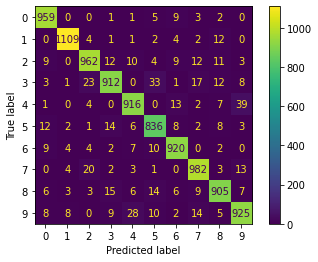

In [6]:
model = load_model('final_model.h5')
trainX, trainY, testX, testY = load_dataset()
testX, testY = prep_pixels(testX, testY)

predicted_values = model.predict(testX , verbose = 0)
plotConfusionMatrix(argmax(testY, axis=1), argmax(predicted_values, axis=1) )

# Part B

## Task 1

In [38]:
from skimage.feature import hog


def image2HOG(data, patchSize):
    num_of_bins = 9
    window = np.array([16, 16])
    imgSize= np.array(data[0].shape[0:2])

    blockSize = np.around( window / patchSize ) #patch_per_window
    blockSize = blockSize.astype('int64')
    # imgSize = np.array([28, 28])

    blockOverlap = np.ceil(blockSize/2)
    blocksPerImage = np.floor((imgSize / patchSize - blockSize) / (blockSize - blockOverlap) + 1)
    hogSIZE = np.prod([ blocksPerImage, blockSize ]) * num_of_bins

    data_HOG = np.empty([data.shape[0], int(hogSIZE)], dtype=np.float64)

    for indx, img in enumerate(data):
        fd = hog(img, orientations=num_of_bins, pixels_per_cell=patchSize, cells_per_block=tuple(blockSize), block_norm='L2', visualize=False, channel_axis=-1)
        data_HOG[indx] = fd

    return data_HOG

patchSize = (5,5)
trainX, trainY, testX, testY = load_dataset()
hogTrainX = image2HOG(trainX, patchSize)

In [16]:
from sklearn import svm

model_SVM = svm.SVC()
model_SVM.fit(hogTrainX, argmax(trainY, axis=1))

SVC()

## Task 2

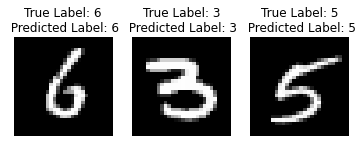

In [62]:
# show results
indxes = range(50,53)
random = testX[indxes]
predictedLabels = model_SVM.predict(image2HOG(testX[indxes], patchSize))
TrueLabels = testY[indxes]

fig, ax = plt.subplots(1,len(indxes))
[axi.set_axis_off() for axi in ax.ravel()]
for count, (ax, indx) in enumerate(zip(ax, indxes)):
    plottable_image = np.reshape(testX[indx], (28, 28))
    ax.imshow(plottable_image, cmap='gray')
    ax.title.set_text(f'True Label: {argmax(TrueLabels[count])}\n Predicted Label: {predictedLabels[count]}')

plt.show()

## Task 3

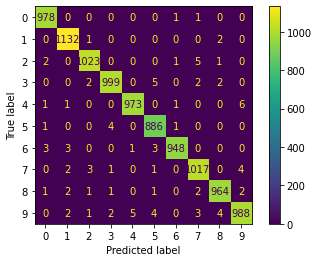

In [19]:
predicted_Labels_SVM = model_SVM.predict(image2HOG(testX, patchSize))
plotConfusionMatrix(argmax(testY, axis=1), predicted_Labels_SVM)